In [ ]:
!pip install torchgan

import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision
from torch.utils.data import Subset, TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

import torchgan
from torchgan.models import ConditionalGANGenerator, ConditionalGANDiscriminator
from torchgan.losses import LeastSquaresGeneratorLoss, LeastSquaresDiscriminatorLoss
from torchgan.trainer import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 71 kB 30 kB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=29c3f875d5d130f5e8825edb69e950018a0a41d131f02254021a54caa851c845
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


### Arguments

In [ ]:
args = {
    'lr': 1e-3, 
    'bs': 128, 
    'epochs': 5,
    'cgan_epochs': 40,
    'num_tasks': 5,
    'dataset': "FashionMNIST",
    'num_classes': 10, 
    'in_size': 32,
    'n_channels': 1,
    'hidden_size': 50
    }

In [ ]:
cgan_network = {
    "generator": {
        "name": ConditionalGANGenerator,
        "args": {
            "encoding_dims": 10,
            "num_classes": 2,
            "out_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": torch.optim.Adam, "args": {"lr": 0.0008, "betas": (0.5, 0.999)}},
    },
    "discriminator": {
        "name": ConditionalGANDiscriminator,
        "args": {
            "num_classes": 2,
            "in_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": torch.optim.Adam, "args": {"lr": 0.0003, "betas": (0.5, 0.999)}},
    },
}


### Data

In [ ]:

def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.5), (0.5)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
    elif dataset == 'FashionMNIST':
        mean, std = (0.5), (0.5)
        
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std),
        torchvision.transforms.Resize((32, 32))])
    
    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )
    
    return train_dataset, val_dataset


def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

### Metrics & plotting

In [ ]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

def show(imgs):
    imgs = imgs[:min(len(imgs), 20)]
    imgs = torch.clip(imgs*0.5 + 0.5, 0, 1)
    grid_img = torchvision.utils.make_grid(imgs, nrow=5).to("cpu")
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

## GAN

In [ ]:
lsgan_losses = [LeastSquaresGeneratorLoss(), LeastSquaresDiscriminatorLoss()]

In [ ]:
def collate_fn(batch):
    examples, labels = zip(*batch)
    unq = np.unique(labels)
    m = {cls:i for i, cls in enumerate(unq)}
    labels = [m[label] for label in labels]
    return torch.stack(examples), torch.Tensor(labels)

## Class incremental model

In [ ]:
class Agent:
    def __init__(self, args, train_datasets, val_datasets, class_split):
        self.args = args
        self.model = MLP(self.args)
        self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
        self.class_split = class_split
        self.gan_trainers = [Trainer(cgan_network, lsgan_losses, sample_size=args['bs'], epochs=args['cgan_epochs'], device=device) 
                             for _ in range(len(class_split))]
        self.samples_per_class = 400
    
    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}

    def generate_data(self, task_idx, loader):
        samples, targets = torch.Tensor([]).to(device), torch.Tensor([]).to(device)
        for sample, target in loader:
            samples = torch.cat((samples, sample.to(device)))
            targets = torch.cat((targets, target.to(device)))
        
        samples = samples[:self.samples_per_class]
        targets = targets[:self.samples_per_class]
        
        for i in range(task_idx):
            for j, cls in enumerate(class_split[str(i)]):
                z = torch.randn(self.samples_per_class, 10, device=device)
                y = torch.Tensor([j]*self.samples_per_class).to(device)
                sample = self.gan_trainers[i].generator.forward(z, y)
                target = torch.Tensor([cls]*self.samples_per_class).to(device)
                
                samples = torch.cat((samples, sample))
                targets = torch.cat((targets, target))
                
        return samples.detach(), targets.type(torch.LongTensor)
            
    def train(self):
        for i, (task, data) in enumerate(self.train_datasets.items()):
            self.model = MLP(self.args)
            self.model.to(device)
             
            dataloader = DataLoader(data, batch_size=self.args['bs'], collate_fn=collate_fn)
            self.gan_trainers[i](dataloader)
            
            dataloader = DataLoader(data, batch_size=self.args['bs'])
            samples, targets = self.generate_data(i, dataloader)
            greedy_dataset = TensorDataset(samples, targets)
            greedy_loader = DataLoader(greedy_dataset, batch_size=self.args['bs'], shuffle=True)
            
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
            for epoch in range(self.args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(greedy_loader):
                    if epoch == 0 and e == 1:
                        print(f"task={task}, classes={self.class_split[task]}")
                        print("sample images:")
                        show(X)
                        
                    X, y = X.to(device), y.to(device)
                    output = self.model(X)
                    loss = self.criterion(output, y)
                    self.optimizer.zero_grad()
                    loss.backward() 
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                    total += len(X)
                    if e % 50 == 0:
                        self.validate()
                print(f"Epoch {epoch}: Loss {epoch_loss/(e+1):.3f} Acc: {correct/total:.3f}")
            self.validate(end_of_epoch=True)


    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                X, y = X.to(device), y.to(device)
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 9.906808376312256
generator Mean Gradients : 2.026721678484202
discriminator Mean Gradients : 27.688091583194158
Mean Running Discriminator Loss : 0.4147487587117134
Mean Running Generator Loss : 0.262119320563479
Generating and Saving Images to ./images/epoch1_generator.png



/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 9.564036846160889
generator Mean Gradients : 1.9168973761868633
discriminator Mean Gradients : 30.584682676826752
Mean Running Discriminator Loss : 0.3832782911176377
Mean Running Generator Loss : 0.2659366064856591
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 9.533690690994263
generator Mean Gradients : 1.6133093877330607
discriminator Mean Gradients : 28.10356344716267
Mean Running Discriminator Loss : 0.3731051119084054
Mean Running Generator Loss : 0.246217359761506
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 9.478298902511597
generator Mean Gradients : 1.4386124229941877
discriminator Mean Gradients : 23.77100068377592
Mean Running Discriminator Loss : 0.3737524289717066
Mean Running Generator Loss : 0.21490958362926993
Gen

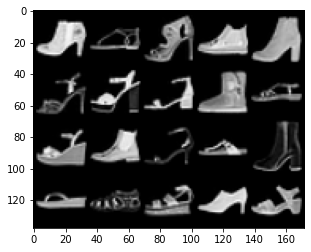

Epoch 0: Loss 2.135 Acc: 0.400
Epoch 1: Loss 1.706 Acc: 0.905
Epoch 2: Loss 1.098 Acc: 0.915
Epoch 3: Loss 0.552 Acc: 0.887
Epoch 4: Loss 0.331 Acc: 0.935
Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 9.579205989837646
generator Mean Gradients : 6.117305648108962
discriminator Mean Gradients : 30.934494047857036
Mean Running Discriminator Loss : 0.4017035682943273
Mean Running Generator Loss : 0.3412778259502994
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 9.579164028167725
generator Mean Gradients : 6.349851431386068
discriminator Mean Gradients : 46.195864062069205
Mean Running Discriminator Loss : 0.31689998689801135
Mean Running Generator Loss : 0.42000143005157525
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 9.503912448883057
generator Mean Gradients : 8.691780489993034

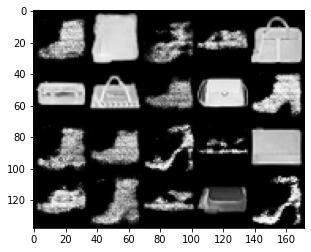

Epoch 0: Loss 1.930 Acc: 0.473
Epoch 1: Loss 0.864 Acc: 0.800
Epoch 2: Loss 0.360 Acc: 0.902
Epoch 3: Loss 0.216 Acc: 0.925
Epoch 4: Loss 0.143 Acc: 0.953
Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 9.64859652519226
generator Mean Gradients : 3.807013665176517
discriminator Mean Gradients : 22.485549331621627
Mean Running Discriminator Loss : 0.4748636499998417
Mean Running Generator Loss : 0.172036757685172
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 9.558882236480713
generator Mean Gradients : 4.096275577448113
discriminator Mean Gradients : 26.026369451731053
Mean Running Discriminator Loss : 0.40949957528488434
Mean Running Generator Loss : 0.29234488518504975
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 9.507598400115967
generator Mean Gradients : 6.337798469276316
d

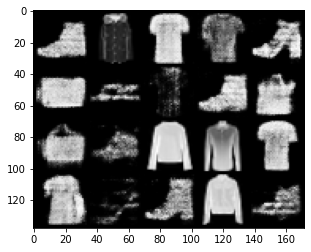

Epoch 0: Loss 1.728 Acc: 0.533
Epoch 1: Loss 0.601 Acc: 0.806
Epoch 2: Loss 0.313 Acc: 0.883
Epoch 3: Loss 0.237 Acc: 0.904
Epoch 4: Loss 0.187 Acc: 0.928
Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 9.456112384796143
generator Mean Gradients : 4.264989800260419
discriminator Mean Gradients : 30.52520707432203
Mean Running Discriminator Loss : 0.4319700192897878
Mean Running Generator Loss : 0.2159463281985038
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 9.486748218536377
generator Mean Gradients : 2.343696148395086
discriminator Mean Gradients : 22.01253718468547
Mean Running Discriminator Loss : 0.4597641110737273
Mean Running Generator Loss : 0.13163012149320205
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 9.469125270843506
generator Mean Gradients : 1.815655683653779
di

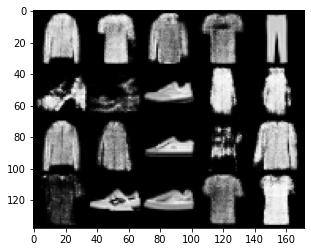

Epoch 0: Loss 1.739 Acc: 0.438
Epoch 1: Loss 0.669 Acc: 0.794
Epoch 2: Loss 0.361 Acc: 0.879
Epoch 3: Loss 0.253 Acc: 0.920
Epoch 4: Loss 0.179 Acc: 0.946
Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 9.411829471588135
generator Mean Gradients : 3.5931227827208128
discriminator Mean Gradients : 24.774559682542378
Mean Running Discriminator Loss : 0.4587795781962415
Mean Running Generator Loss : 0.20689334774317317
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 9.43042778968811
generator Mean Gradients : 2.9767035732406404
discriminator Mean Gradients : 30.21171835765989
Mean Running Discriminator Loss : 0.3847157149872881
Mean Running Generator Loss : 0.3186474581806206
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 9.355393171310425
generator Mean Gradients : 3.010340724741688


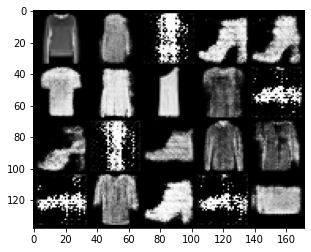

Epoch 0: Loss 1.516 Acc: 0.536
Epoch 1: Loss 0.562 Acc: 0.799
Epoch 2: Loss 0.365 Acc: 0.869
Epoch 3: Loss 0.252 Acc: 0.916
Epoch 4: Loss 0.185 Acc: 0.943


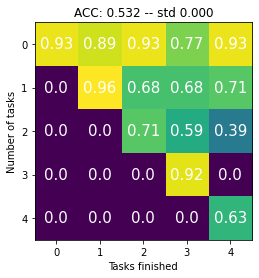

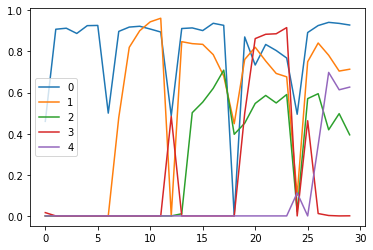

The average accuracy at the end of sequence is: 0.533
BWT:'-0.369'
FWT:'-0.009'


In [ ]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)
agent = Agent(args, train_tasks, val_tasks, class_split)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")